## 사전 작업

In [ ]:
import os, sys
from google.colab import drive

drive.mount('/content/drive')
my_path = '/content/package'
save_path = '/content/drive/MyDrive/Colab Notebooks/package'  # 패키지가 저장될 경로

# 기존 심볼릭 링크가 존재하면 삭제
if os.path.islink(my_path):
    os.unlink(my_path)

os.symlink(save_path, my_path)
sys.path.insert(0, my_path)


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

## 대출 상환 모델

In [ ]:
from sklearn.tree import DecisionTreeClassifier # 결정트리
from sklearn.ensemble import BaggingClassifier # 배깅
from sklearn.linear_model import LogisticRegression # 로지스틱회귀
from sklearn.neighbors import KNeighborsClassifier # KNN

In [ ]:
from sklearn.model_selection import cross_validate # 교차타당도
from sklearn.pipeline import make_pipeline # 파이프라인 구축
from sklearn.model_selection import learning_curve, validation_curve # 학습곡선, 검증곡선
from sklearn.model_selection import GridSearchCV # 하이퍼 파라미터 튜닝
from sklearn.model_selection import cross_val_score # 교차타당도

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report # 정오분류표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc # ROC 곡선 그리기

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/repayment.csv', header=0)
data = data.dropna()
print(data.shape)
print(list(data.columns))

(2000, 5)
['clientid', 'income', 'age', 'loan', 'repayment']


In [ ]:
data.head()

,clientid,income,age,loan,repayment
0,1,66156,59,8107,0
1,2,34415,48,6565,0
2,3,57317,63,8021,0
3,4,42710,46,6104,0
4,5,66953,19,8770,1


In [ ]:
data.drop('clientid', axis=1, inplace=True)

- 특징선택과 데이터 나누기

In [ ]:
data_input = data[['income', 'age', 'loan']].values
data_target = data[['repayment']].values

In [ ]:
from sklearn.model_selection import train_test_split
# 데이터셋을 훈련 세트와, 테스트 세트로 나누기 (Train 75%, Test 25%)
x_train, x_test, y_train, y_test = train_test_split(data_input, data_target, test_size=0.25, random_state=42)

In [ ]:
# 데이터 크기 확인
train_size = len(x_train)
test_size = len(x_test)

# 전체 데이터 크기
total_size = train_size + test_size

# 비율 확인
train_ratio = train_size / total_size
test_ratio = test_size / total_size

# 결과 출력
print(f'Train set size: {train_size}, ratio: {train_ratio:.2f}')
print(f'Test set size: {test_size}, ratio: {test_ratio:.2f}')

Train set size: 1500, ratio: 0.75
Test set size: 500, ratio: 0.25


- 정규화

In [ ]:
from sklearn.preprocessing import StandardScaler

s1 = StandardScaler()
train_scaled = s1.fit_transform(x_train)
test_scaled = s1.transform(x_test)

> Bagging

- 분류 모델 세팅

In [ ]:
repay_log = LogisticRegression(random_state=42)

repay_bag = BaggingClassifier(base_estimator= repay_log, # base model logistic regression모델 사용
                            n_estimators=1000, # 데이터 샘플 개수
                            max_samples=0.9,
                            max_features=1.0,
                            bootstrap=True,
                            bootstrap_features=False,
                            n_jobs=1,
                            random_state=1)

clf_labels = ['Logistic Regression', 'Bagging']
all_clf = [repay_log, repay_bag]

- 모델 검정

In [ ]:
y_train = y_train.astype(int).ravel()
y_test = y_test.astype(int).ravel()

In [ ]:
for clf, label in zip (all_clf, clf_labels):
  scores = cross_val_score(estimator=clf,
                           X = train_scaled,
                           y = y_train,
                           cv = 10,
                           scoring = 'roc_auc',
                           error_score='raise'
                          )
  print("ROC AUC: %0.3f (+/- %0.3f) %s"
        %(scores.mean(), scores.std(), label))

ROC AUC: 0.985 (+/- 0.007) Logistic Regression
ROC AUC: 0.985 (+/- 0.007) Bagging


<function matplotlib.pyplot.show(close=None, block=None)>

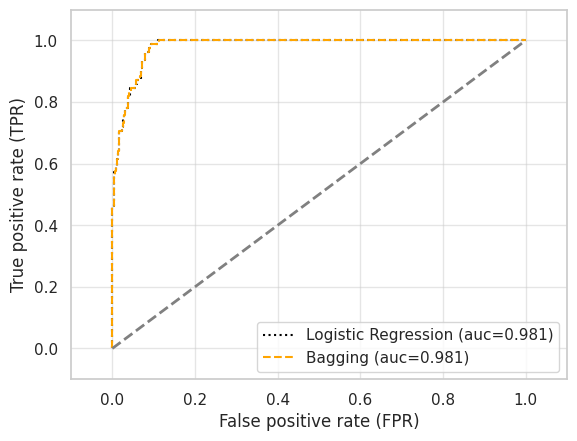

In [ ]:
colors = ['black', 'orange']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls \
      in zip(all_clf, clf_labels, colors, linestyles):

      clf.fit(train_scaled, y_train)
      y_pred = clf.predict_proba(test_scaled)[:, 1]
      fpr, tpr, thresholds = roc_curve(y_true = y_test,
                                       y_score = y_pred)
      roc_auc = auc(x=fpr, y =tpr)
      plt.plot(fpr, tpr,
               color=clr,
               linestyle=ls,
               label='%s (auc=%0.3f)' %(label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0,1], [0,1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show

In [ ]:
repay_bag.fit(train_scaled, y_train)

BaggingClassifier(base_estimator=LogisticRegression(random_state=42),
                  max_samples=0.9, n_estimators=1000, n_jobs=1, random_state=1)

In [ ]:
y_pred = repay_bag.predict(test_scaled)

In [ ]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['repayment[0]','repayment[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
repayment[0],409,13
repayment[1],17,61


In [ ]:
print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())# 총 500개 중에
print('정확도: %.3f' %accuracy_score(y_test, y_pred)) # 올바르게 예측한 비율
print('정밀도: %.3f' %precision_score(y_true=y_test, y_pred=y_pred)) # 양성 예측 중 실제 양성인 것
print('재현율: %.3f' %recall_score(y_true=y_test, y_pred=y_pred)) # 실제 양성 중에서 올바르게 양성으로 예측
print('F1: %.3f' %f1_score(y_true=y_test, y_pred=y_pred)) # 정밀도와 재현율의 조화 평균

잘못 분류된 샘플 개수: 30
정확도: 0.940
정밀도: 0.824
재현율: 0.782
F1: 0.803


> Random Forest

- 분류 모델 세팅

In [ ]:
from sklearn.ensemble import RandomForestClassifier# RandomForestClassifier
repay_tree2 = DecisionTreeClassifier(max_depth=None,
                              criterion='entropy',
                              random_state=1)

repay_forest2 = RandomForestClassifier(criterion='gini',
                                n_estimators=1000,
                                random_state=1)

clf_labels = ['Decision Tree', 'Random_Forest']
all_clf = [repay_tree2, repay_forest2]

- 모델 검정

In [ ]:
for clf, label in zip (all_clf, clf_labels):
  scores = cross_val_score(estimator=clf,
                           X = train_scaled,
                           y = y_train,
                           cv = 10,
                           scoring = 'roc_auc',
                           error_score='raise')
  print("ROC AUC: %0.3f (+/- %0.3f) [%s"
        %(scores.mean(), scores.std(), label))

ROC AUC: 0.961 (+/- 0.022) [Decision Tree
ROC AUC: 0.998 (+/- 0.002) [Random_Forest


<function matplotlib.pyplot.show(close=None, block=None)>

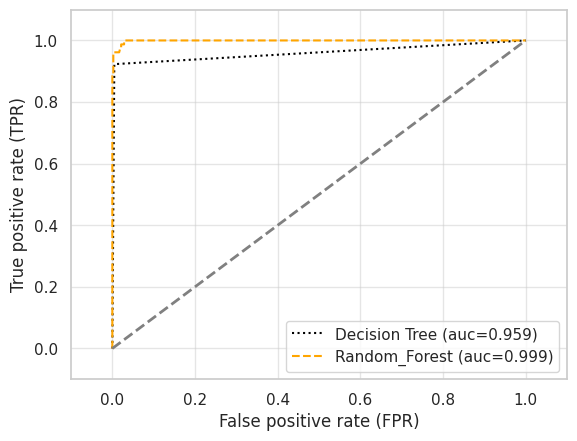

In [ ]:
colors = ['black', 'orange']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls \
      in zip(all_clf, clf_labels, colors, linestyles):

      clf.fit(train_scaled, y_train)
      y_pred = clf.predict_proba(test_scaled)[:, 1]
      fpr, tpr, thresholds = roc_curve(y_true = y_test,
                                       y_score = y_pred)
      roc_auc = auc(x=fpr, y =tpr)
      plt.plot(fpr, tpr,
               color=clr,
               linestyle=ls,
               label='%s (auc=%0.3f)' %(label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0,1], [0,1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show

In [ ]:
repay_forest2.fit(train_scaled, y_train)

RandomForestClassifier(n_estimators=1000, random_state=1)

In [ ]:
y_pred = repay_forest2.predict(test_scaled)

In [ ]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['repayment[0]','repayment[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
repayment[0],421,1
repayment[1],8,70


In [ ]:
print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum()) # 총 500개 중에
print('정확도: %.3f' %accuracy_score(y_test, y_pred)) # 올바르게 예측한 비율
print('정밀도: %.3f' %precision_score(y_true=y_test, y_pred=y_pred)) # 양성 예측 중 실제 양성인 것
print('재현율: %.3f' %recall_score(y_true=y_test, y_pred=y_pred)) # 실제 양성 중에서 올바르게 양성으로 예측
print('F1: %.3f' %f1_score(y_true=y_test, y_pred=y_pred)) # 정밀도와 재현율의 조화 평균

잘못 분류된 샘플 개수: 9
정확도: 0.982
정밀도: 0.986
재현율: 0.897
F1: 0.940


> Voting

- 분류모델 세팅

In [ ]:
from sklearn.ensemble import VotingClassifier# VotingClassfier

repay_tree3 = DecisionTreeClassifier(max_depth=None,
                              criterion='entropy',
                              random_state=1)

repay_log3 = LogisticRegression(random_state=42)

repay_knn3 = KNeighborsClassifier(n_neighbors=3)

repay_voting3 = VotingClassifier(estimators = [('logistic', repay_log3), ('tree', repay_tree3), ('knn', repay_knn3) ],
                          voting='soft')

clf_labels = ['Logistic Regression','KNeighbors Classifier','Decision Tree', 'Majority voting']
all_clf = [repay_log3, repay_knn3, repay_tree3, repay_voting3]

- 모델 검정

In [ ]:
for clf, label in zip (all_clf, clf_labels):
  scores = cross_val_score(estimator=clf,
                           X = train_scaled,
                           y = y_train,
                           cv = 10,
                           scoring = 'roc_auc',
                           error_score='raise')
  print("ROC AUC: %0.3f (+/- %0.3f) [%s"
        %(scores.mean(), scores.std(), label))

ROC AUC: 0.985 (+/- 0.007) [Logistic Regression
ROC AUC: 0.994 (+/- 0.007) [KNeighbors Classifier
ROC AUC: 0.961 (+/- 0.022) [Decision Tree
ROC AUC: 0.998 (+/- 0.001) [Majority voting


<function matplotlib.pyplot.show(close=None, block=None)>

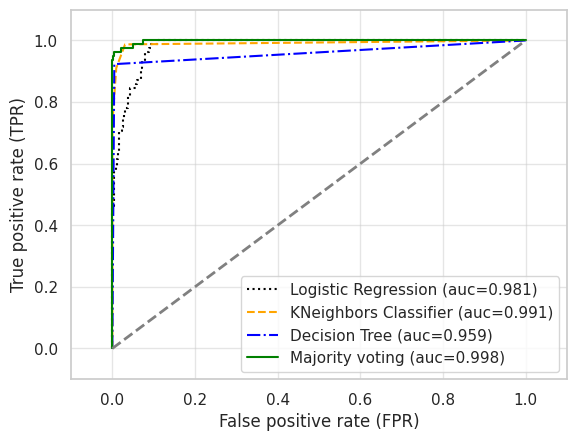

In [ ]:
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls \
      in zip(all_clf, clf_labels, colors, linestyles):

      clf.fit(train_scaled, y_train)
      y_pred = clf.predict_proba(test_scaled)[:, 1]
      fpr, tpr, thresholds = roc_curve(y_true = y_test,
                                       y_score = y_pred)
      roc_auc = auc(x=fpr, y =tpr)
      plt.plot(fpr, tpr,
               color=clr,
               linestyle=ls,
               label='%s (auc=%0.3f)' %(label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0,1], [0,1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show

In [ ]:
repay_voting3.fit(x_train, y_train)

VotingClassifier(estimators=[('logistic', LogisticRegression(random_state=42)),
                             ('tree',
                              DecisionTreeClassifier(criterion='entropy',
                                                     random_state=1)),
                             ('knn', KNeighborsClassifier(n_neighbors=3))],
                 voting='soft')

In [ ]:
y_pred = repay_voting3.predict(x_test)

In [ ]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['repayment[0]','repayment[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
repayment[0],422,0
repayment[1],16,62


In [ ]:
print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())# 총 500개 중에
print('정확도: %.3f' %accuracy_score(y_test, y_pred)) # 올바르게 예측한 비율
print('정밀도: %.3f' %precision_score(y_true=y_test, y_pred=y_pred)) # 양성 예측 중 실제 양성인 것
print('재현율: %.3f' %recall_score(y_true=y_test, y_pred=y_pred)) # 실제 양성 중에서 올바르게 양성으로 예측
print('F1: %.3f' %f1_score(y_true=y_test, y_pred=y_pred)) # 정밀도와 재현율의 조화 평균

잘못 분류된 샘플 개수: 16
정확도: 0.968
정밀도: 1.000
재현율: 0.795
F1: 0.886


> Ada Boost

- 분류모델 세팅

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
repay_tree4 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=1)

repay_ada4 = AdaBoostClassifier(base_estimator= repay_tree4,
                              n_estimators=1000,
                              learning_rate = 0.1,#hyper 수정
                              random_state = 1)

clf_labels = ['Decision Tree', 'Ada boost']
all_clf = [repay_tree4, repay_ada4]

- 모델 검정

In [ ]:
for clf, label in zip (all_clf, clf_labels):
  scores = cross_val_score(estimator=clf,
                           X = train_scaled,
                           y = y_train,
                           cv = 10,
                           scoring = 'roc_auc',
                           error_score='raise')
  print("ROC AUC: %0.3f (+/- %0.3f) [%s"
        %(scores.mean(), scores.std(), label))

ROC AUC: 0.859 (+/- 0.012) [Decision Tree
ROC AUC: 0.998 (+/- 0.002) [Ada boost


<function matplotlib.pyplot.show(close=None, block=None)>

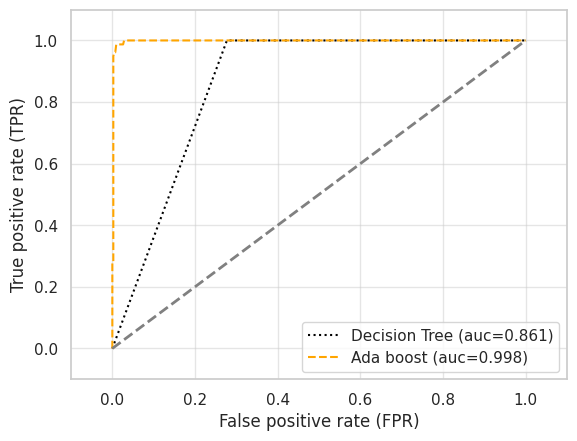

In [ ]:
colors = ['black', 'orange']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls \
      in zip(all_clf, clf_labels, colors, linestyles):

      clf.fit(train_scaled, y_train)
      y_pred = clf.predict_proba(test_scaled)[:, 1]
      fpr, tpr, thresholds = roc_curve(y_true = y_test,
                                       y_score = y_pred)
      roc_auc = auc(x=fpr, y =tpr)
      plt.plot(fpr, tpr,
               color=clr,
               linestyle=ls,
               label='%s (auc=%0.3f)' %(label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0,1], [0,1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show

In [ ]:
repay_ada4.fit(train_scaled, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=1,
                                                         random_state=1),
                   learning_rate=0.1, n_estimators=1000, random_state=1)

In [ ]:
y_pred = repay_ada4.predict(test_scaled)

In [ ]:
confmat = pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['repayment[0]','repayment[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
repayment[0],421,1
repayment[1],5,73


In [ ]:
print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())# 총 500개 중에
print('정확도: %.3f' %accuracy_score(y_test, y_pred)) # 올바르게 예측한 비율
print('정밀도: %.3f' %precision_score(y_true=y_test, y_pred=y_pred)) # 양성 예측 중 실제 양성인 것
print('재현율: %.3f' %recall_score(y_true=y_test, y_pred=y_pred)) # 실제 양성 중에서 올바르게 양성으로 예측
print('F1: %.3f' %f1_score(y_true=y_test, y_pred=y_pred)) # 정밀도와 재현율의 조화 평균

잘못 분류된 샘플 개수: 6
정확도: 0.988
정밀도: 0.986
재현율: 0.936
F1: 0.961


## 대출 승인 모델

> 데이터셋 불러오기

In [ ]:
data2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Loan_Data.csv', header=0)
data2 = data2.dropna()
print(data2.shape)
print(list(data2.columns))

(557, 12)
['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Income', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']


In [ ]:
data2.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Income,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0.0,Graduate,No,5849.0,0.0,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1.0,Graduate,No,6091.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0.0,Graduate,Yes,3000.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0.0,Not Graduate,No,4941.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0.0,Graduate,No,6000.0,141.0,360.0,1.0,Urban,Y


> 시각화

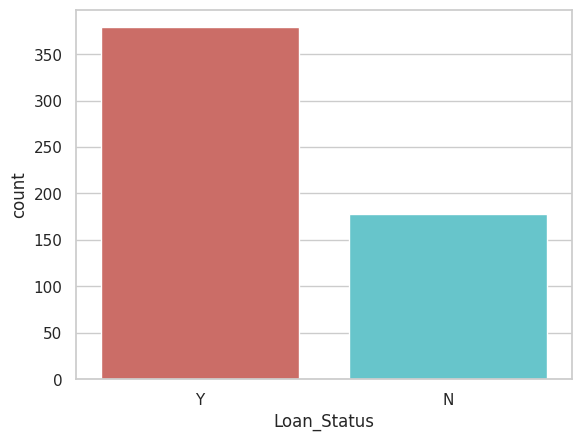

Loan_status Y의 비율: 0.68
Loan_status N의 비율: 0.32


In [ ]:
sns.countplot(x='Loan_Status',data=data2, palette='hls')
plt.show()
print('Loan_status Y의 비율: %.2f' %(data2['Loan_Status'].value_counts()[0]/len(data2)))
print('Loan_status N의 비율: %.2f' %(data2['Loan_Status'].value_counts()[1]/len(data2)))

Text(0, 0.5, 'Loan_status Frequency')

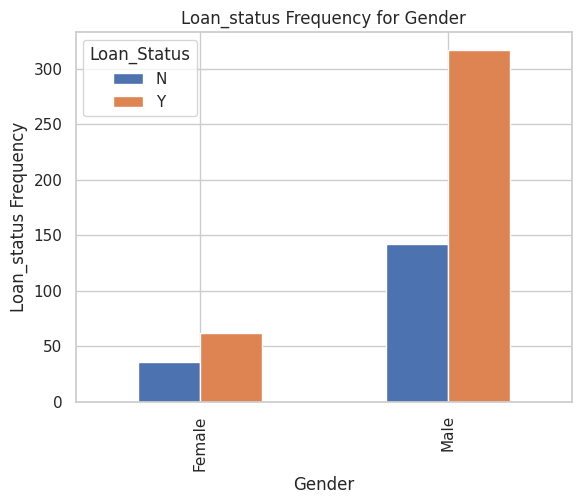

In [ ]:
%matplotlib inline
pd.crosstab(data2.Gender,data2.Loan_Status).plot(kind='bar')
plt.title('Loan_status Frequency for Gender')
plt.xlabel('Gender')
plt.ylabel('Loan_status Frequency')

Text(0, 0.5, 'Loan_status Frequency')

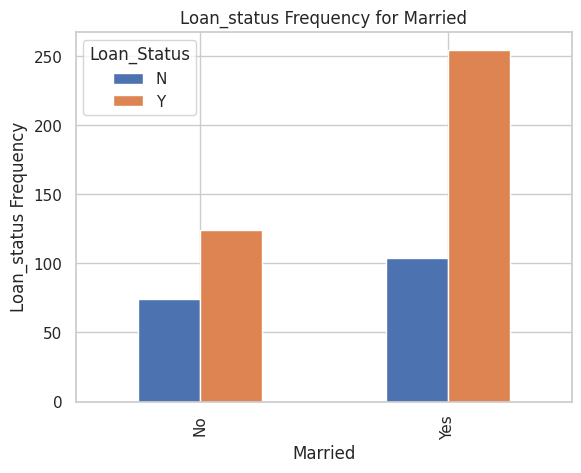

In [ ]:
%matplotlib inline
pd.crosstab(data2.Married,data2.Loan_Status).plot(kind='bar')
plt.title('Loan_status Frequency for Married')
plt.xlabel('Married')
plt.ylabel('Loan_status Frequency')

Text(0, 0.5, 'Loan_status Frequency')

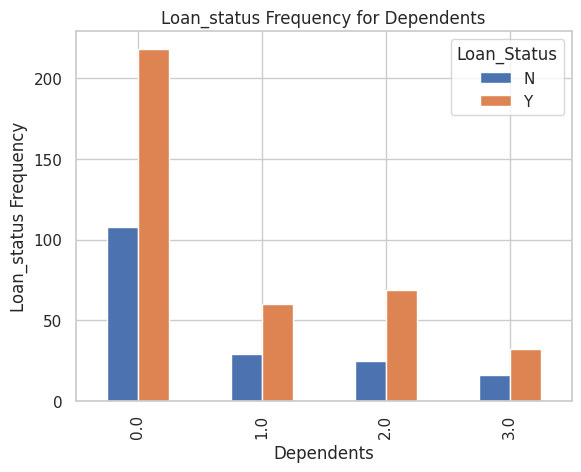

In [ ]:
%matplotlib inline
pd.crosstab(data2.Dependents,data2.Loan_Status).plot(kind='bar')
plt.title('Loan_status Frequency for Dependents')
plt.xlabel('Dependents')
plt.ylabel('Loan_status Frequency')

Text(0, 0.5, 'Loan_status Frequency')

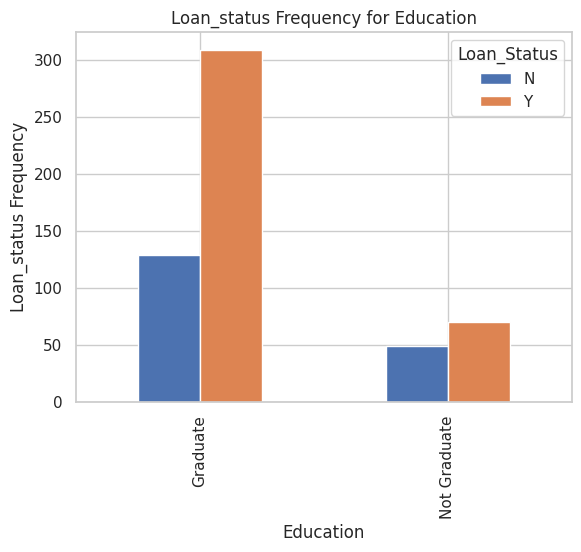

In [ ]:
%matplotlib inline
pd.crosstab(data2.Education,data2.Loan_Status).plot(kind='bar')
plt.title('Loan_status Frequency for Education')
plt.xlabel('Education')
plt.ylabel('Loan_status Frequency')

Text(0, 0.5, 'Loan_status Frequency')

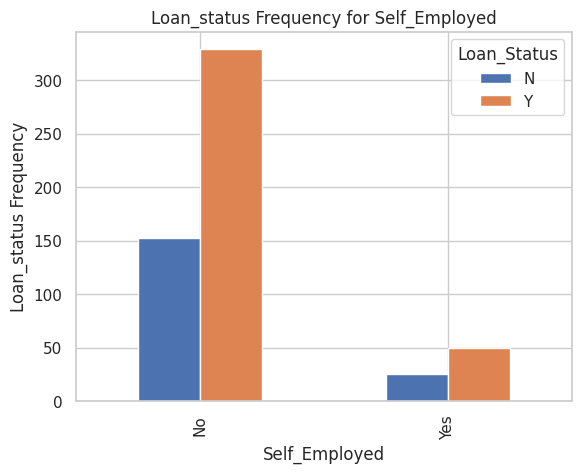

In [ ]:
%matplotlib inline
pd.crosstab(data2.Self_Employed,data2.Loan_Status).plot(kind='bar')
plt.title('Loan_status Frequency for Self_Employed')
plt.xlabel('Self_Employed')
plt.ylabel('Loan_status Frequency')

Text(0, 0.5, 'Loan_status Frequency')

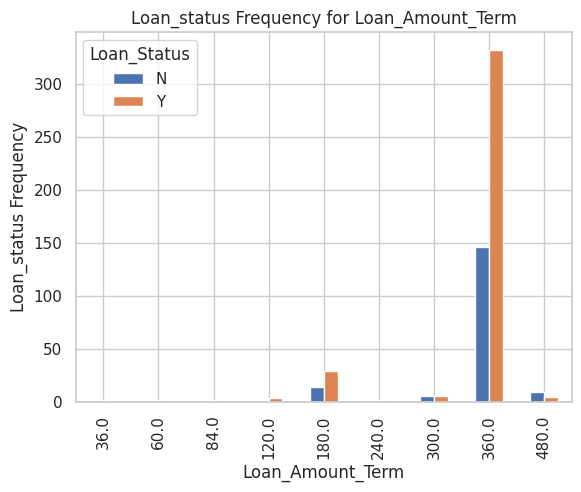

In [ ]:
%matplotlib inline
pd.crosstab(data2.Loan_Amount_Term,data2.Loan_Status).plot(kind='bar')
plt.title('Loan_status Frequency for Loan_Amount_Term')
plt.xlabel('Loan_Amount_Term')
plt.ylabel('Loan_status Frequency')

Text(0, 0.5, 'Loan_status Frequency')

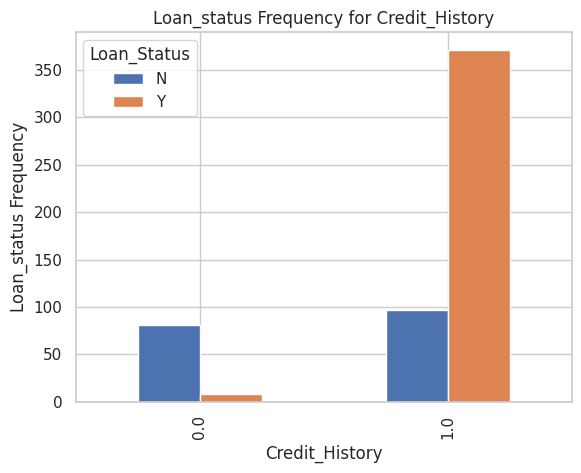

In [ ]:
%matplotlib inline
pd.crosstab(data2.Credit_History,data2.Loan_Status).plot(kind='bar')
plt.title('Loan_status Frequency for Credit_History')
plt.xlabel('Credit_History')
plt.ylabel('Loan_status Frequency')

Text(0, 0.5, 'Loan_status Frequency')

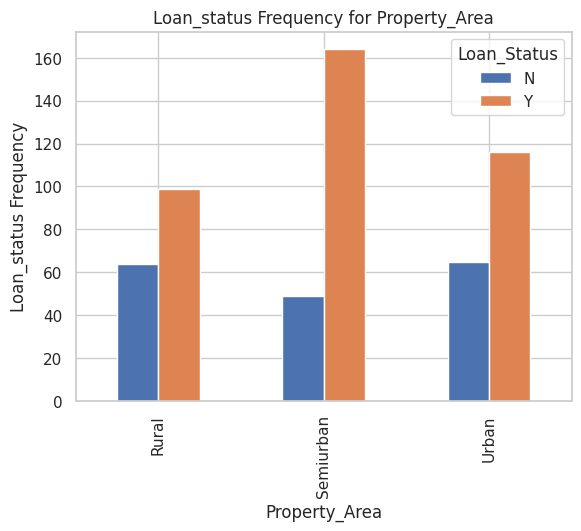

In [ ]:
%matplotlib inline
pd.crosstab(data2.Property_Area,data2.Loan_Status).plot(kind='bar')
plt.title('Loan_status Frequency for Property_Area')
plt.xlabel('Property_Area')
plt.ylabel('Loan_status Frequency')

> 데이터 전처리

In [ ]:
data2.drop('Loan_ID', axis=1, inplace=True)

In [ ]:
data2['Gender']=np.where(data2['Gender'] =='Male', 0, data2['Gender'])
data2['Gender']=np.where(data2['Gender'] =='Female', 1, data2['Gender'])

In [ ]:
data2['Married']=np.where(data2['Married'] =='Yes', 1, data2['Married'])
data2['Married']=np.where(data2['Married'] =='No', 0, data2['Married'])

In [ ]:
data2['Education']=np.where(data2['Education'] =='Graduate', 1, data2['Education'])
data2['Education']=np.where(data2['Education'] =='Not Graduate', 0, data2['Education'])

In [ ]:
data2['Self_Employed']=np.where(data2['Self_Employed'] =='Yes', 1, data2['Self_Employed'])
data2['Self_Employed']=np.where(data2['Self_Employed'] =='No', 0, data2['Self_Employed'])

In [ ]:
data2['Property_Area']=np.where(data2['Property_Area'] =='Urban', 0, data2['Property_Area'])
data2['Property_Area']=np.where(data2['Property_Area'] =='Rural', 1, data2['Property_Area'])
data2['Property_Area']=np.where(data2['Property_Area'] =='Semiurban', 2, data2['Property_Area'])

In [ ]:
data2['Loan_Status']=np.where(data2['Loan_Status'] =='Y', 1, data2['Loan_Status'])
data2['Loan_Status']=np.where(data2['Loan_Status'] =='N', 0, data2['Loan_Status'])

In [ ]:
data2.head()

,Gender,Married,Dependents,Education,Self_Employed,Income,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0,0,0.0,1,0,5849.0,0.0,360.0,1.0,0,1
1,0,1,1.0,1,0,6091.0,128.0,360.0,1.0,1,0
2,0,1,0.0,1,1,3000.0,66.0,360.0,1.0,0,1
3,0,1,0.0,0,0,4941.0,120.0,360.0,1.0,0,1
4,0,0,0.0,1,0,6000.0,141.0,360.0,1.0,0,1


> 특징 선택과 데이터 나누기

In [ ]:
data2_input = data2[['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Income',
                   'LoanAmount','Loan_Amount_Term', 'Credit_History', 'Property_Area']].values
data2_target = data2[['Loan_Status']].values

In [ ]:
from sklearn.model_selection import train_test_split
# 데이터셋을 훈련 세트와, 테스트 세트로 나누기 (Train 75%, Test 25%)
x_train2, x_test2, y_train2, y_test2 = train_test_split(data2_input, data2_target, test_size=0.25, random_state=42)

In [ ]:
# 데이터 크기 확인
train_size = len(x_train2)
test_size = len(x_test2)

# 전체 데이터 크기
total_size = train_size + test_size

# 비율 확인
train_ratio = train_size / total_size
test_ratio = test_size / total_size

# 결과 출력
print(f'Train set size: {train_size}, ratio: {train_ratio:.2f}')
print(f'Test set size: {test_size}, ratio: {test_ratio:.2f}')

Train set size: 417, ratio: 0.75
Test set size: 140, ratio: 0.25


> 정규화

In [ ]:
from sklearn.preprocessing import StandardScaler

s2 = StandardScaler()
train_scaled2 = s2.fit_transform(x_train2)
test_scaled2 = s2.transform(x_test2)

> Bagging

- 분류 모델 세팅

In [ ]:
loan_tree = DecisionTreeClassifier(max_depth=None,
                              criterion='entropy',
                              random_state=1)

loan_log = LogisticRegression(random_state=42)

loan_bag = BaggingClassifier(base_estimator=loan_log, # 로그모델 사용
                            n_estimators= 600, # 데이터 샘플 개수, 로지스틱 모델 300개 만들어서 돌림(총데이터의 50%)
                            max_samples=0.9,
                            max_features=1.0,
                            bootstrap=True, # 샘플 중복 학습
                            bootstrap_features=False,
                            n_jobs=1,
                            random_state=1)

clf_labels = ['Logistic Regression', 'Bagging']
all_clf = [loan_log, loan_bag]

- 모델 검정

In [ ]:
y_train2 = y_train2.astype(int).ravel()
y_test2 = y_test2.astype(int).ravel()

In [ ]:
for clf, label in zip (all_clf, clf_labels):
  scores = cross_val_score(estimator=clf,
                           X = train_scaled2,
                           y = y_train2,
                           cv = 10,
                           scoring = 'roc_auc',
                           error_score='raise')
  print("ROC AUC: %0.3f (+/- %0.3f) [%s"
        %(scores.mean(), scores.std(), label))

ROC AUC: 0.764 (+/- 0.055) [Logistic Regression
ROC AUC: 0.761 (+/- 0.057) [Bagging


<function matplotlib.pyplot.show(close=None, block=None)>

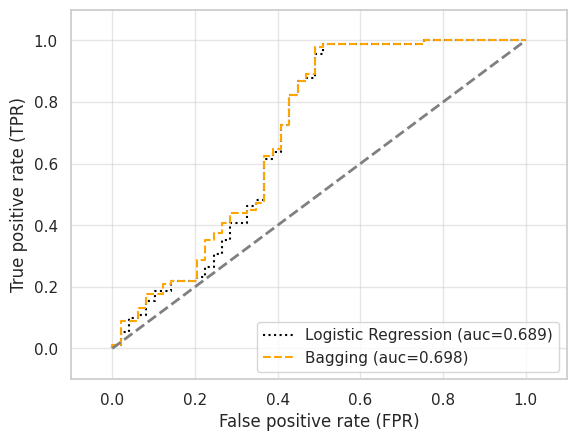

In [ ]:
colors = ['black', 'orange']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls \
      in zip(all_clf, clf_labels, colors, linestyles):

      clf.fit(train_scaled2, y_train2)
      y_pred2 = clf.predict_proba(test_scaled2)[:, 1]
      fpr, tpr, thresholds = roc_curve(y_true = y_test2,
                                       y_score = y_pred2)
      roc_auc = auc(x=fpr, y =tpr)
      plt.plot(fpr, tpr,
               color=clr,
               linestyle=ls,
               label='%s (auc=%0.3f)' %(label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0,1], [0,1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show

점선 절반은 맞춘 것
score에 있어서는 logistic보다 bagging이 더 낮지만  
(아마 모델자체가 이진분류여서 그런듯)
auc는 bagging이 더 높음
(양성 class를 더 잘 분류함 TPR)

In [ ]:
loan_bag.fit(train_scaled2, y_train2)

BaggingClassifier(base_estimator=LogisticRegression(random_state=42),
                  max_samples=0.9, n_estimators=600, n_jobs=1, random_state=1)

In [ ]:
y_pred2 = loan_bag.predict(test_scaled2)

In [ ]:
confmat = pd.DataFrame(confusion_matrix(y_test2, y_pred2),
                      index=['Loan_status[0]','Loan_status[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
Loan_status[0],23,26
Loan_status[1],1,90


In [ ]:
print('잘못 분류된 샘플 개수: %d' % (y_test2 != y_pred2).sum())# 총 140개 중에
print('정확도: %.3f' %accuracy_score(y_test2, y_pred2)) # 올바르게 예측한 비율
print('정밀도: %.3f' %precision_score(y_true=y_test2, y_pred=y_pred2)) # 양성 예측 중 실제 양성인 것 87 / 109
print('재현율: %.3f' %recall_score(y_true=y_test2, y_pred=y_pred2)) # 실제 양성 중에서 올바르게 양성으로 예측  87/91
print('F1: %.3f' %f1_score(y_true=y_test2, y_pred=y_pred2)) # 정밀도와 재현율의 조화 평균

잘못 분류된 샘플 개수: 27
정확도: 0.807
정밀도: 0.776
재현율: 0.989
F1: 0.870


> Random Forest

- 분류 모델 세팅

In [ ]:
from sklearn.ensemble import RandomForestClassifier# RandomForestClassifier
loan_tree2 = DecisionTreeClassifier(max_depth=None,
                              criterion='entropy',
                              random_state=1)

loan_forest2 = RandomForestClassifier(criterion='gini',
                                n_estimators=600,
                                random_state=1)

clf_labels = ['Decision Tree', 'Random_Forest']
all_clf = [loan_tree2, loan_forest2]

- 모델 검정

In [ ]:
for clf, label in zip (all_clf, clf_labels):
  scores = cross_val_score(estimator=clf,
                           X = train_scaled2,
                           y = y_train2,
                           cv = 10,
                           scoring = 'roc_auc',
                           error_score='raise')
  print("ROC AUC: %0.3f (+/- %0.3f) [%s"
        %(scores.mean(), scores.std(), label))

ROC AUC: 0.638 (+/- 0.068) [Decision Tree
ROC AUC: 0.733 (+/- 0.075) [Random_Forest


<function matplotlib.pyplot.show(close=None, block=None)>

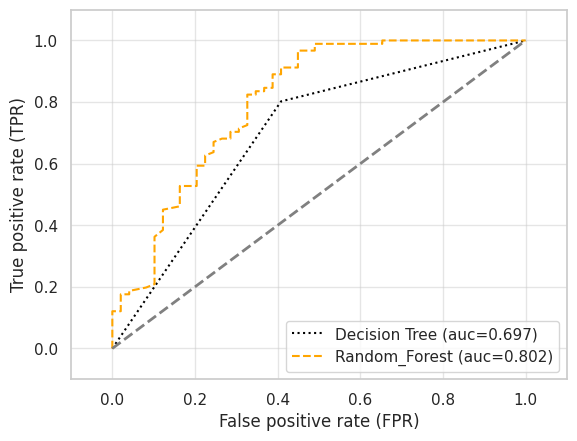

In [ ]:
colors = ['black', 'orange']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls \
      in zip(all_clf, clf_labels, colors, linestyles):

      clf.fit(train_scaled2, y_train2)
      y_pred2 = clf.predict_proba(test_scaled2)[:, 1]
      fpr, tpr, thresholds = roc_curve(y_true = y_test2,
                                       y_score = y_pred2)
      roc_auc = auc(x=fpr, y =tpr)
      plt.plot(fpr, tpr,
               color=clr,
               linestyle=ls,
               label='%s (auc=%0.3f)' %(label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0,1], [0,1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show

In [ ]:
loan_forest2.fit(train_scaled2, y_train2)

RandomForestClassifier(n_estimators=600, random_state=1)

In [ ]:
y_pred2 = loan_forest2.predict(test_scaled2)

In [ ]:
confmat = pd.DataFrame(confusion_matrix(y_test2, y_pred2),
                      index=['Loan_status[0]','Loan_status[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
Loan_status[0],27,22
Loan_status[1],7,84


In [ ]:
print('잘못 분류된 샘플 개수: %d' % (y_test2 != y_pred2).sum())# 총 140개 중에
print('정확도: %.3f' %accuracy_score(y_test2, y_pred2)) # 올바르게 예측한 비율
print('정밀도: %.3f' %precision_score(y_true=y_test2, y_pred=y_pred2)) # 양성 예측 중 실제 양성인 것
print('재현율: %.3f' %recall_score(y_true=y_test2, y_pred=y_pred2)) # 실제 양성 중에서 올바르게 양성으로 예측
print('F1: %.3f' %f1_score(y_true=y_test2, y_pred=y_pred2)) # 정밀도와 재현율의 조화 평균

잘못 분류된 샘플 개수: 29
정확도: 0.793
정밀도: 0.792
재현율: 0.923
F1: 0.853


> Voting

In [ ]:
from sklearn.ensemble import VotingClassifier# VotingClassfier

loan_tree3 = DecisionTreeClassifier(max_depth=None,
                              criterion='entropy',
                              random_state=1)

loan_log3 = LogisticRegression(random_state=42)

loan_knn3 = KNeighborsClassifier(n_neighbors=3)

loan_voting3 = VotingClassifier(estimators = [('logistic', loan_log3), ('tree', loan_tree3), ('knn', loan_knn3) ],
                          voting='soft')

clf_labels = ['Logistic Regression','KNeighbors Classifier','Decision Tree', 'Majority voting']
all_clf = [loan_log3, loan_knn3, loan_tree3, loan_voting3]

In [ ]:
for clf, label in zip (all_clf, clf_labels):
  scores = cross_val_score(estimator=clf,
                           X = train_scaled2,
                           y = y_train2,
                           cv = 10,
                           scoring = 'roc_auc',
                           error_score='raise')
  print("ROC AUC: %0.3f (+/- %0.3f) [%s"
        %(scores.mean(), scores.std(), label))

ROC AUC: 0.764 (+/- 0.055) [Logistic Regression
ROC AUC: 0.700 (+/- 0.065) [KNeighbors Classifier
ROC AUC: 0.638 (+/- 0.068) [Decision Tree
ROC AUC: 0.729 (+/- 0.057) [Majority voting


<function matplotlib.pyplot.show(close=None, block=None)>

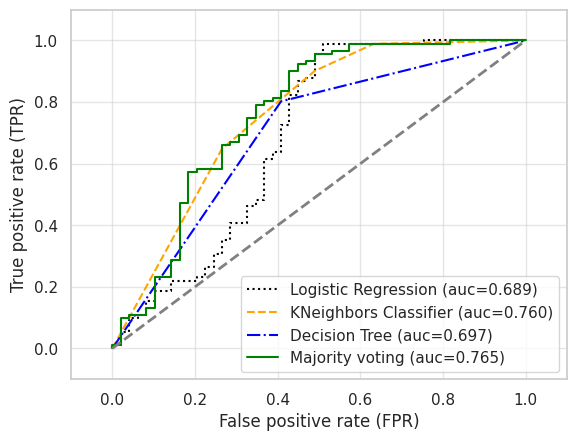

In [ ]:
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls \
      in zip(all_clf, clf_labels, colors, linestyles):

      clf.fit(train_scaled2, y_train2)
      y_pred2 = clf.predict_proba(test_scaled2)[:, 1]
      fpr, tpr, thresholds = roc_curve(y_true = y_test2,
                                       y_score = y_pred2)
      roc_auc = auc(x=fpr, y =tpr)
      plt.plot(fpr, tpr,
               color=clr,
               linestyle=ls,
               label='%s (auc=%0.3f)' %(label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0,1], [0,1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show

In [ ]:
loan_voting3.fit(x_train2, y_train2)

VotingClassifier(estimators=[('logistic', LogisticRegression(random_state=42)),
                             ('tree',
                              DecisionTreeClassifier(criterion='entropy',
                                                     random_state=1)),
                             ('knn', KNeighborsClassifier(n_neighbors=3))],
                 voting='soft')

In [ ]:
y_pred2 = loan_voting3.predict(x_test2)

In [ ]:
confmat = pd.DataFrame(confusion_matrix(y_test2, y_pred2),
                      index=['Loan_status[0]','Loan_status[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
Loan_status[0],24,25
Loan_status[1],11,80


In [ ]:
print('잘못 분류된 샘플 개수: %d' % (y_test2 != y_pred2).sum())# 총 140개 중에
print('정확도: %.3f' %accuracy_score(y_test2, y_pred2)) # 올바르게 예측한 비율  111/140
print('정밀도: %.3f' %precision_score(y_true=y_test2, y_pred=y_pred2)) # 양성 예측 중 실제 양성인 것 84 / 106
print('재현율: %.3f' %recall_score(y_true=y_test2, y_pred=y_pred2)) # 실제 양성 중에서 올바르게 양성으로 예측  84/91
print('F1: %.3f' %f1_score(y_true=y_test2, y_pred=y_pred2)) # 정밀도와 재현율의 조화 평균

잘못 분류된 샘플 개수: 36
정확도: 0.743
정밀도: 0.762
재현율: 0.879
F1: 0.816


> AdaBoost

초기 샘플 데이터를 뽑아내고 다수의 분류기를 생성 분류기 순차적으로 훈련, 훈련과정에서 앞모델이 틀렸던 부분에 가중치를 부여하여 진행.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
loan_tree4 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=1)

loan_ada4 = AdaBoostClassifier(base_estimator=loan_tree4,
                              n_estimators=600,
                              learning_rate = 0.1,#hyper 수정
                              random_state = 1)

clf_labels = ['Decision Tree', 'Ada boost']
all_clf = [loan_tree4, loan_ada4]

In [ ]:
for clf, label in zip (all_clf, clf_labels):
  scores = cross_val_score(estimator=clf,
                           X = train_scaled2,
                           y = y_train2,
                           cv = 10,
                           scoring = 'roc_auc',
                           error_score='raise')
  print("ROC AUC: %0.3f (+/- %0.3f) [%s"
        %(scores.mean(), scores.std(), label))

ROC AUC: 0.712 (+/- 0.068) [Decision Tree
ROC AUC: 0.745 (+/- 0.076) [Ada boost


<function matplotlib.pyplot.show(close=None, block=None)>

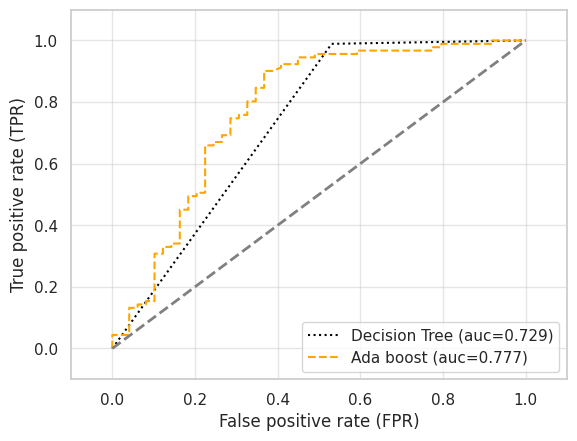

In [ ]:
colors = ['black', 'orange']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls \
      in zip(all_clf, clf_labels, colors, linestyles):

      clf.fit(train_scaled2, y_train2)
      y_pred2 = clf.predict_proba(test_scaled2)[:, 1]
      fpr, tpr, thresholds = roc_curve(y_true = y_test2,
                                       y_score = y_pred2)
      roc_auc = auc(x=fpr, y =tpr)
      plt.plot(fpr, tpr,
               color=clr,
               linestyle=ls,
               label='%s (auc=%0.3f)' %(label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0,1], [0,1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show

In [ ]:
loan_ada4.fit(train_scaled2, y_train2)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=1,
                                                         random_state=1),
                   learning_rate=0.1, n_estimators=600, random_state=1)

In [ ]:
y_pred2 = loan_ada4.predict(test_scaled2)

In [ ]:
confmat = pd.DataFrame(confusion_matrix(y_test2, y_pred2),
                      index=['Loan_status[0]','Loan_status[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
Loan_status[0],25,24
Loan_status[1],5,86


In [ ]:
print('잘못 분류된 샘플 개수: %d' % (y_test2 != y_pred2).sum())# 총 140개 중에
print('정확도: %.3f' %accuracy_score(y_test2, y_pred2)) # 올바르게 예측한 비율
print('정밀도: %.3f' %precision_score(y_true=y_test2, y_pred=y_pred2)) # 양성 예측 중 실제 양성인 것
print('재현율: %.3f' %recall_score(y_true=y_test2, y_pred=y_pred2)) # 실제 양성 중에서 올바르게 양성으로 예측
print('F1: %.3f' %f1_score(y_true=y_test2, y_pred=y_pred2)) # 정밀도와 재현율의 조화 평균

잘못 분류된 샘플 개수: 29
정확도: 0.793
정밀도: 0.782
재현율: 0.945
F1: 0.856


## 대출 심사

* 아래와 같은 카테고리에 맞춰 고객의 인적 사항을 입력합니다.
- Age: 고객의 나이입니다.
- Gender: 고객의 성별('남성' 또는 '여성')입니다.
- Married: 고객의 결혼 유무입니다.
- Dependents: 고객의 자식 수입니다.
- Education: 고객의 의무교육 수료 여부입니다.
- Self_Employed: 고객이 자영업자인지에 대한 여부입니다.
- Income: 고객의 연봉입니다. (단위는 달러)
- Loan: 고객이 보유했던 대출 원금
- LoanAmount: 고객이 대출하고자 하는 금액입니다. (단위는 달러)
- Loan_Amount_Term: 고객이 원하는 대출 상환 기한입니다. (단위는 달러)
- Credit_History: 고객의 신용 정보입니다.
- Property_Area: 고객의 거주 지역입니다.

> Input Example

In [ ]:
'''
고객의 인적 사항을 기입합니다. [성공]
'''
Age = 20
Gender = 0 # Male = 1, Female = 0
Married = 0 # Yes = 1, No = 0
Dependents = 0 # 자식의 수가 0, 1, 2, 3(3명 이상)
Education = 1 # Graduate = 1, Not Graduate = 0
Self_Employed = 0 # Yes = 1, No = 0
Income = 50000 # 연봉 기준
Loan = 1000 # 보유했던 대출 원금
LoanAmount = 100 # 대출하고자 하는 금액
Loan_Amount_Term = 360 # 원하는 대출 상환 기한
Credit_History = 1 # 신용 기록 (신용 점수 양호 = 1)
Property_Area = 1 # Urban = 0, Rural = 1, Semiurban = 2

In [ ]:
'''
고객의 인적 사항을 기입합니다. [상환 능력 불충분]
'''
Age = 20
Gender = 0 # Male = 1, Female = 0
Married = 0 # Yes = 1, No = 0
Dependents = 0 # 0, 1, 2, 3
Education = 1 # Graduate = 1, Not Graduate = 0
Self_Employed = 0 # Yes = 1, No = 0
Income = 50000 # 연봉 기준
Loan = 10000 # 보유했던 대출 원금
LoanAmount = 100 # 대출하고자 하는 금액
Loan_Amount_Term = 360 # 원하는 대출 상환 기한
Credit_History = 1 # 신용 기록 (신용 점수 양호 = 1)
Property_Area = 1 # Urban = 0, Rural = 1, Semiurban = 2

In [ ]:
'''
    고객의 인적 사항을 기입합니다. [최종 승인 불가]
'''
Age = 20
Gender = 0 # Male = 1, Female = 0
Married = 0 # Yes = 1, No = 0
Dependents = 0 # 0, 1, 2, 3
Education = 1 # Graduate = 1, Not Graduate = 0
Self_Employed = 0 # Yes = 1, No = 0
Income = 50000 # 연봉 기준
Loan = 1000 # 보유했던 대출 원금
LoanAmount = 1000 # 대출하고자 하는 금액
Loan_Amount_Term = 360 # 원하는 대출 상환 기한
Credit_History = 1 # 신용 기록 (신용 점수 양호 = 1)
Property_Area = 1 # Urban = 0, Rural = 1, Semiurban = 2

> 최종 모델

In [ ]:
'''
    repayment가 0이면 상환 능력이 충분, 1이면 상환 능력이 부족

    여기서 말하는 상환 능력이란 대출하고자 하는 금액에 따른 것이 아닌 신용도에 가까운 상환 능력을 말함

    loan_status가 0이면 대출 거절, 1이면 대출 승인
'''
repay_model = repay_ada
loan_model = loan_bag

repay_feature = np.array([[Income, Age, Loan]])
loan_feature = np.array([[Gender, Married, Dependents, Education, Self_Employed,
                         Income / 12, LoanAmount, Loan_Amount_Term, Credit_History, Property_Area]])

client_step1 = s1.transform(repay_feature)
client_step2 = s2.transform(loan_feature)

if (repay_model.predict(client_step1) == 0): # Step1. 해당 고객이 상환할 능력이 충분한지 예측
  if (loan_model.predict(client_step2) == 0): # Step2. 해당 고객에 대해 최종 대출 심사
    print('대출이 승인되었습니다.')
  else:
    print('대출이 불가합니다. [최종 승인 불가]')
else:
  print('대출이 불가합니다. [상환 능력 불충분]')



NotFittedError: This BaggingClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.